## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Какурин Василий Владимирович

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import itertools
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов (1 балл)

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

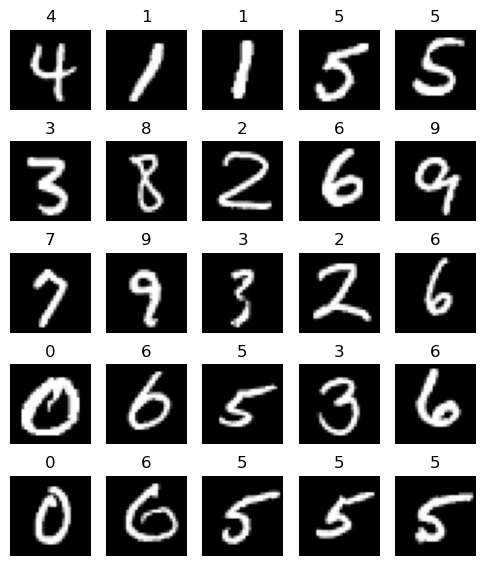

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [61]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layers = list(
    itertools.chain.from_iterable(
        [(nn.Linear(28*28, 500), nn.Tanh())] +\
        [(nn.Linear(500, 500), nn.Tanh()) for i in range(10)] +\
        [(nn.Linear(500, 10), nn.Tanh())]
        )
    )

for i,layer in enumerate(layers):
    layer.register_forward_hook(forward_hook)
    if(i%2==1): continue
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [62]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0106183290481567
forward 2.856105089187622
forward 0.8528568744659424
forward 1.885662317276001
forward 0.7852206826210022
forward 1.750974416732788
forward 0.7689502239227295
forward 1.732125997543335
forward 0.7690685391426086
forward 1.716820240020752
forward 0.7653301358222961
forward 1.725148320198059
forward 0.7657650709152222
forward 1.7087894678115845
forward 0.7635748386383057
forward 1.712019443511963
forward 0.7657729983329773
forward 1.6938347816467285
forward 0.7623723745346069
forward 1.707127571105957
forward 0.7651795148849487
forward 1.7220194339752197
forward 0.7662765979766846
forward 1.7424644231796265
backward 0.014280484989285469
backward 0.006427962798625231
backward 0.006516770925372839
backward 0.006876100320369005
backward 0.007002844940871
backward 0.007704210001975298
backward 0.008986555971205235
backward 0.009887928143143654
backward 0.01210820022970438
backward 0.013741109520196915
backward 0.015670286491513252
backward 0.015591658651828766


Для forward, нечётные строки - std после активации (0-й, 1-й, ...), чётные - после линейного слоя (1-го, 2-го, ...). Дисперсия и std после применения линейных слоёв изменяются согласно формулам. После активации дисперсия уменьшается, т.к. Tanh близка к линейной функции только в окрестности 0, а при удалении от 0 все значения группируются в окрестностях -1 и 1, соответственно, дисперсия уменьшается.

У градиентов происходит увеличение дисперсии, опять же, согласно формулам, на каждом шаге где было линейное преобразование

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [63]:
def Xavier_init_layer(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    v = np.sqrt(6/(weight.shape[0] + weight.shape[1]))
    weight.uniform_(-v, v)
    
def He_init_layer(layer):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2/weight.shape[1]))

In [64]:
layers = list(
    itertools.chain.from_iterable(
        [(nn.Linear(28*28, 500), nn.Tanh())] +\
        [(nn.Linear(500, 500), nn.Tanh()) for i in range(10)] +\
        [(nn.Linear(500, 10), nn.Tanh())]
        )
    )

for i,layer in enumerate(layers):
    layer.register_forward_hook(forward_hook)
    if(i%2==1): continue
    layer.register_backward_hook(backward_hook)
    Xavier_init_layer(layer)
    
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0106183290481567
forward 1.1308822631835938
forward 0.6578995585441589
forward 0.6496047377586365
forward 0.4959256052970886
forward 0.48974916338920593
forward 0.4101504683494568
forward 0.4052795171737671
forward 0.3553297221660614
forward 0.3510470688343048
forward 0.31633254885673523
forward 0.3187483549118042
forward 0.2920704185962677
forward 0.2937765121459961
forward 0.2721933126449585
forward 0.2689835727214813
forward 0.2523280084133148
forward 0.2522355020046234
forward 0.23805175721645355
forward 0.23491454124450684
forward 0.22330066561698914
forward 0.22655385732650757
forward 0.2160511016845703
forward 0.320117712020874
backward 0.025962790474295616
backward 0.018102336674928665
backward 0.018187420442700386
backward 0.0164943840354681
backward 0.015290931798517704
backward 0.014097020961344242
backward 0.012956056743860245
backward 0.011006671003997326
backward 0.009499866515398026
backward 0.007548222783952951
backward 0.005673871375620365
backward 0.00331343

In [65]:
layers = list(
    itertools.chain.from_iterable(
        [(nn.Linear(28*28, 500), nn.Tanh())] +\
        [(nn.Linear(500, 500), nn.Tanh()) for i in range(10)] +\
        [(nn.Linear(500, 10), nn.Tanh())]
        )
    )

for i,layer in enumerate(layers):
    layer.register_forward_hook(forward_hook)
    if(i%2==1): continue
    layer.register_backward_hook(backward_hook)
    He_init_layer(layer)
    
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0106183290481567
forward 1.4121230840682983
forward 0.7141140103340149
forward 1.0053058862686157
forward 0.6291020512580872
forward 0.887230634689331
forward 0.5929613709449768
forward 0.8322905898094177
forward 0.5730452537536621
forward 0.8167867064476013
forward 0.5664798617362976
forward 0.8056198358535767
forward 0.5628229379653931
forward 0.7876125574111938
forward 0.5566755533218384
forward 0.7808527946472168
forward 0.554348349571228
forward 0.7769884467124939
forward 0.5522471070289612
forward 0.7817882895469666
forward 0.5528861284255981
forward 0.7868650555610657
forward 0.5566706657409668
forward 0.7853677868843079
backward 0.024996722117066383
backward 0.010814251378178596
backward 0.010975133627653122
backward 0.011389408260583878
backward 0.010992736555635929
backward 0.011246180161833763
backward 0.010741489939391613
backward 0.010543577373027802
backward 0.010322723537683487
backward 0.00968935713171959
backward 0.008562903851270676
backward 0.00665161712095

<i> 1.4 Сделайте выводы по первой части </i>

Для инициализации Xavier - удалось достичь сохранения дисперсии на каждом шаге (линейный слой, активация) (подряд идущие пары в forward). Также, удалось достичь слабого изменения дисперсии градиентов.

Для инициализации He - результаты, ожидаемо ,получились хуже, т.к. эта инициализация подразумевает, что функцией активации будет ReLU, а не Tanh. Дисперсия forward слоёв сильно изменяется на каждом линейном слое и на каждом слое активации. Но, дисперсии градиентов оказались гораздо более стабильными.

### Часть 2: Dropout (1 балл)

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [83]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        if self.training:
            mask = torch.bernoulli(torch.full_like(self.linear.weight, self.p))
        else:
            mask = torch.full_like(self.linear.weight, self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [73]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 29... (Train/Test) NLL: 1.325/0.359	Accuracy: 0.487/0.881


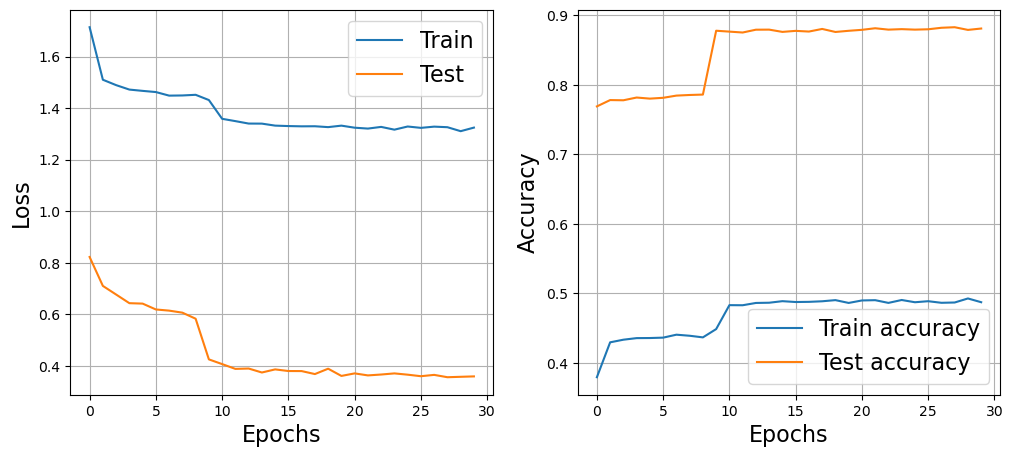

CPU times: total: 15min 1s
Wall time: 16min 13s


([1.7142691360607838,
  1.5103963361874317,
  1.4894466153594221,
  1.4721829718364072,
  1.467158199881694,
  1.462566326676147,
  1.4487045812708483,
  1.4493645968467697,
  1.4518988010471563,
  1.4315228520680083,
  1.3586898615111167,
  1.3497203545275527,
  1.3402655755024728,
  1.3400065672677208,
  1.3322736045190775,
  1.3305505176088703,
  1.3295029920301458,
  1.3298152010323905,
  1.3264257821447052,
  1.332189261023678,
  1.3242038137622987,
  1.3207954974062661,
  1.3272999695369176,
  1.3165766487497765,
  1.328839751957322,
  1.3235620333950149,
  1.3283173560079482,
  1.3261273589723908,
  1.3106797931036716,
  1.3245694932144587],
 [0.8222897890247877,
  0.7099953414518622,
  0.6765022236335126,
  0.6429534905318972,
  0.6412951323804976,
  0.6185401810120933,
  0.6140309640123874,
  0.6061320825468136,
  0.5826617758485335,
  0.4247219128699242,
  0.40647456993030595,
  0.38784133935276466,
  0.38926611501204816,
  0.3738547679555567,
  0.38589755341976506,
  0.37954

In [93]:
%%time
from train_utils import train

layers = [nn.Linear(196, 128), nn.Dropout(), nn.ReLU(),
          nn.Linear(128, 128), nn.Dropout(), nn.ReLU(),
          nn.Linear(128, 10), nn.Dropout(), nn.ReLU()]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 30, 0.001, device='cuda')

Epoch 29... (Train/Test) NLL: 0.121/0.069	Accuracy: 0.965/0.979


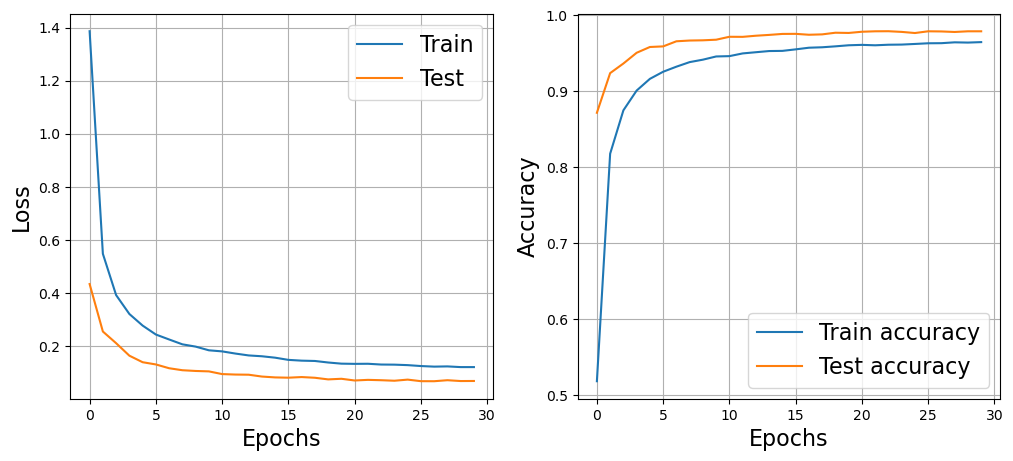

CPU times: total: 15min 41s
Wall time: 19min 41s


([1.3861877816572372,
  0.5480570956460957,
  0.3925167328195531,
  0.32138408463138507,
  0.27774355568484205,
  0.24405383369498163,
  0.22541236359554567,
  0.20714005448225972,
  0.1985435290996835,
  0.18463833933509488,
  0.18055652863562488,
  0.17237729164583088,
  0.16533947492967535,
  0.1621941663046826,
  0.15684522413559307,
  0.14861572977862378,
  0.1456721875645808,
  0.14445443605896888,
  0.13871635634031124,
  0.13438002206980865,
  0.13358031181908492,
  0.13395394241091793,
  0.13104571977546856,
  0.1306112505781498,
  0.128819374131289,
  0.12537456414640458,
  0.12317197448186783,
  0.12402824946701019,
  0.12139847382569491,
  0.12141198311040778],
 [0.43411376129222823,
  0.2553991658400886,
  0.211426674282249,
  0.16437128959577293,
  0.1398039300442685,
  0.1313666244850883,
  0.11710013265285311,
  0.1096168427574861,
  0.10683473885719534,
  0.10525039559866808,
  0.09508669711177863,
  0.09333055452266827,
  0.09274235294978547,
  0.08577882431306039,
  

In [94]:
%%time
layers = [DropConnect(196, 128), nn.ReLU(),
          DropConnect(128, 128), nn.ReLU(),
          DropConnect(128, 10), nn.ReLU()]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 30, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

При использовании DropConnect ошибка на test медленнее уменьшается в начале обучения, чем при использовании Dropout, но далее результаты становятся практически одинаковыми. На train части Dropout даёт существенно большее значение ошибки, и существенно меньшее качество чем DropConnect. Таким образом, два метода практически идентичны по качеству работы, но, DropConnect на train показывает существенно более близкие к test значения метрик, чем Dropout.

### Часть 3: Batch Normalization (3 балла)

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [90]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x-x.mean(dim=1, keepdim=True))/x.std(dim=1, keepdim=True)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 29... (Train/Test) NLL: 0.008/0.096	Accuracy: 0.997/0.976


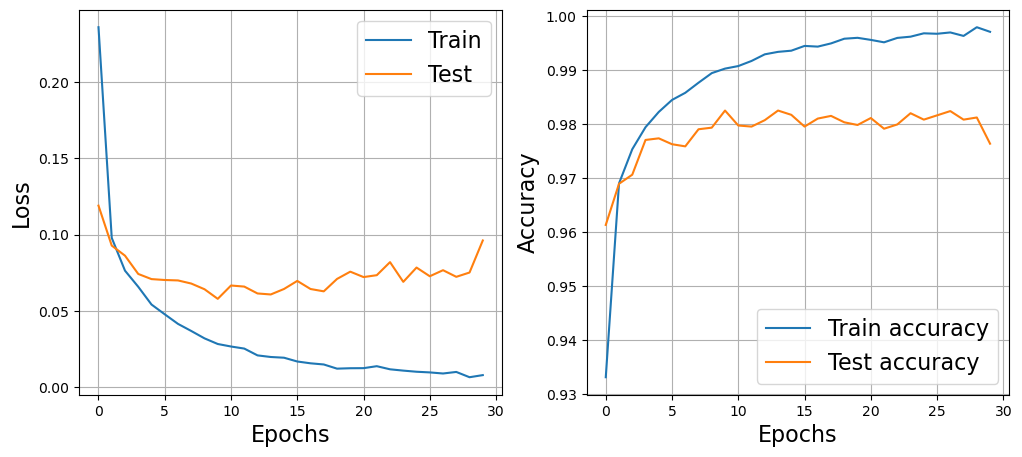

CPU times: total: 16min 20s
Wall time: 19min 20s


([0.2357862214369179,
  0.09787278370395588,
  0.07640350421568923,
  0.06585356722405153,
  0.054237356872113146,
  0.04783751038330069,
  0.04156073413715799,
  0.03691535715414866,
  0.032087169554350634,
  0.02839326776483698,
  0.026749293732919545,
  0.025400438168367095,
  0.02093821716644287,
  0.01988810375317939,
  0.019412779352262315,
  0.016939477208241727,
  0.015751381507585212,
  0.014990091284819897,
  0.012256589154640871,
  0.012526631090806912,
  0.012582859372720618,
  0.013864503219735615,
  0.011828300211103763,
  0.010968402843394412,
  0.010231367960909326,
  0.009793705856879312,
  0.009081979007932416,
  0.010101651367621554,
  0.0066431863322030694,
  0.008022369493375163],
 [0.1189745116177239,
  0.09282412912838067,
  0.08621988153155846,
  0.07425261614254758,
  0.0708805174932261,
  0.07029388366337819,
  0.07001155551782326,
  0.06797333583206268,
  0.06424570215266946,
  0.057962528208883694,
  0.06668521304720942,
  0.06598159960320785,
  0.0614819714

In [95]:
%%time
layers = [nn.Linear(196, 128), nn.ReLU(), nn.BatchNorm1d(128),
          nn.Linear(128, 128), nn.ReLU(), nn.BatchNorm1d(128),
          nn.Linear(128, 10), nn.ReLU()]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 30, 0.001, device='cuda')

Epoch 29... (Train/Test) NLL: 0.007/0.081	Accuracy: 0.998/0.982


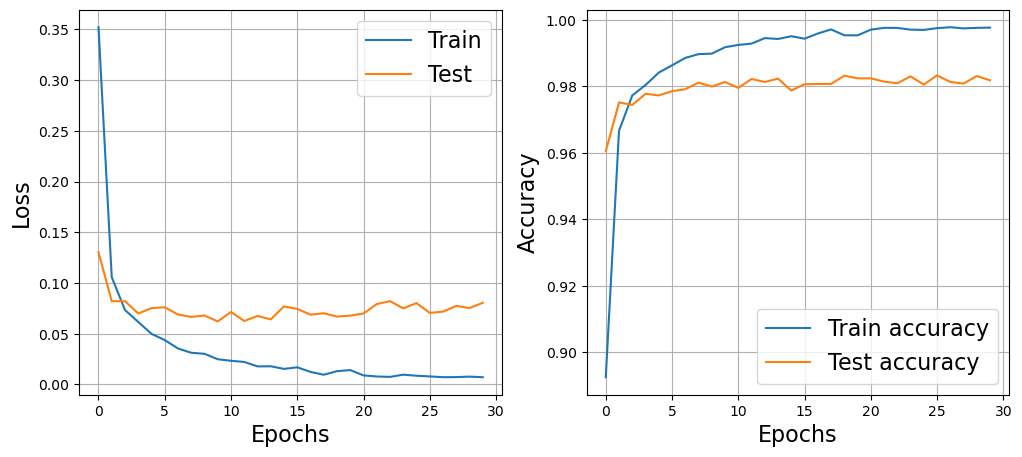

CPU times: total: 16min 14s
Wall time: 19min 42s


([0.35206316545732746,
  0.10573975342725005,
  0.07337088317973718,
  0.06161589817360425,
  0.04988769337590506,
  0.04377193175661348,
  0.03546753944332666,
  0.03125092682382986,
  0.03022412468926477,
  0.02486728587602851,
  0.023339098464496045,
  0.022203054148773316,
  0.017833919250724046,
  0.017933714618188525,
  0.015359789540649637,
  0.016932996263271317,
  0.012370201905242113,
  0.009603565239672934,
  0.013118335349943989,
  0.014181369717835065,
  0.008926415077928426,
  0.007877726133821332,
  0.007476451091570353,
  0.009655324642940897,
  0.008622328454367584,
  0.007939399899211157,
  0.007177298253647604,
  0.0072673936226406565,
  0.007751788547086189,
  0.007154651689170021],
 [0.13028826630568202,
  0.08211589071758185,
  0.08203857679721675,
  0.07000483888425404,
  0.07523725557294261,
  0.07610350650959188,
  0.06895446501483646,
  0.06658605875188037,
  0.06797534235770802,
  0.06215716080881561,
  0.07143518262943607,
  0.06254782504107378,
  0.06754786

In [96]:
%%time
layers = [nn.Linear(196, 128), nn.ReLU(), LayerNormalization(),
          nn.Linear(128, 128), nn.ReLU(), LayerNormalization(),
          nn.Linear(128, 10), nn.ReLU()]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 30, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Оба метода показали хороший результат, и между ними наблюдается значимых отличий. Вероятно, это следствие того, что данные довольно чистые, и задача довольно простая, так что оба метода одинаково хорошо с ней справляются

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: